# Getting started with Superwise.ai on AWS Sagemaker

In this notebook, we will demonstrate how to integrate a Sagemaker based development workflow with Superwise.ai

Part I of this notebook walks you through building a classical Linear Regression model for predicting diamond prices, using Sci-kit learn on SageMaker. 
It is based on [AWS Sagemaker's example for building a Scikit-Learn model](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_randomforest/Sklearn_on_SageMaker_end2end.ipynb).

Part II of this notebook will walk you through how to setup Superwise.ai to start tracking your model, by registering and providing a baseline for the model's behavior.

Part III will demonstrate how to send new predictions from your model to Superwise.ai, simulating a post-deployment scenario.

At this point, you should be able to start seeing insights from Superwise.ai in the web portal.


## Part I - building a Sagemaker Model to predict diamond prices

This is a classical LinearRegression mode, that uses a publicly available dataset.

This guide is based on the best practices from [AWS Sagemaker's example for building a Scikit-Learn model](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_randomforest/Sklearn_on_SageMaker_end2end.ipynb)


### Prerequisites

1. A Superwise.ai account that enables you to login and view insights
2. A set of API keys for sending data to Superwise.ai 
3. Permissions to create models, training jobs and inference endpoints inside Sagemaker
4. Grant Superwise.ai permissions to your SageMaker bucket #soon to be removed

Note: this notebook works best when run from within a [Sagemaker's notebook](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html) instance

### Setup

In [47]:
import datetime
import time
import tarfile


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


import boto3
from sagemaker import get_execution_role
import sagemaker


sm_boto3 = boto3.client("sagemaker")

sess = sagemaker.Session()

region = sess.boto_session.region_name

bucket = sess.default_bucket()  # this could also be a hard-coded bucket name

print("Using bucket " + bucket)

### Prepare data
We load a dataset from sklearn, split it and send it to S3

In [5]:
# we use the Diamond prices dataset 
df = pd.read_csv('https://www.openml.org/data/get_csv/21792853/dataset')

In [6]:
print(df.shape)
df.head(3)

(53940, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


#### Dataset Description     
This dataset contains the prices and other attributes of almost 54,000 diamonds.  
- price price in US dollars (\$326--\$18,823)  
- carat weight of the diamond (0.2--5.01)  
- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)  
- color diamond colour, from J (worst) to D (best)  
- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))  
- x length in mm (0--10.74)   
- y width in mm (0--58.9)  
- z depth in mm (0--31.8)  
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)  


#### Split the data intro train and test sets

In [7]:
X = df.drop(columns="price")
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Upload the data into S3 so that Sagemaker can access it

In [8]:
train = X_train.copy()
train["price"] = y_train

test = X_test.copy()
test["price"] = y_test

train.to_csv("diamonds_train.csv")
test.to_csv("diamonds_test.csv")

# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path="diamonds_train.csv", bucket=bucket, key_prefix="sagemaker/sklearncontainer"
)

testpath = sess.upload_data(
    path="diamonds_test.csv", bucket=bucket, key_prefix="sagemaker/sklearncontainer"
)


### Creating the Script for Training and Inference
The following script contains both training and inference functionality. 

It is designed so that it can run both in SageMaker Training hardware or locally (desktop, SageMaker notebook, on prem, etc). 

Detailed guidance [here](https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#preparing-the-scikit-learn-training-script)

**Note**

In order to support the integration with Superwise.ai, our Inference API expects **a unique ID** to be sent along with the features for prediction.

Later on, this ID will be sent over to Superwise.ai, enabling analysis such as correlation between prediciton and late-arriving labels.


In [9]:
%%writefile script.py

import argparse
import joblib
import os
from io import BytesIO

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


feature_column_names = [
    'carat',
    'cut',
    'color',
    'clarity', 
    'depth',
    'table',
    'x',
    'y',
    'z'
    ]

label_column = 'price'

id_column = 'id_col'


# inference functions
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


def input_fn(input_data, content_type):
    """Parse input data payload

    We expect a serialized numpy array as input.
    The numpy array should contain, as the first column, a unique ID, followed by the feature values.
    """
    if content_type == "application/x-npy":
        # Read the raw input
        load_bytes = BytesIO(input_data)
        input_np = np.load(load_bytes, allow_pickle=True)
        num_columns = input_np.shape[1]
        
        # Expect the first column to be a unique ID 
        if num_columns != len(feature_column_names) + 1: 
            raise ValueError(f"payload needs to contain {len(feature_column_names) + 1} columns, with first column being the ID of the record")
        df_columns = [id_column] + feature_column_names
        df = pd.DataFrame(data=input_np, columns=df_columns) 
        return df
    else:
        raise ValueError(f"content type {content_type} is not supported by this inference endpoint. Please send a legal application/x-npy payload")

        
# TODO - check if need to roll it back to the client or will SM track it as part of the input-output correlation
                         
def predict_fn(input_data, model):
    # predict using the features
    prediction = model.predict(input_data[feature_column_names])
    # Concatenate the ID column to the predictions to keep track 
    return np.stack((input_data[id_column], prediction), axis=1 )


# Model training function
if __name__ == "__main__":

    print("extracting arguments")
    parser = argparse.ArgumentParser()
    
    
    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--n-jobs", type=int, default=1)
    
    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="diamonds_train.csv")
    parser.add_argument("--test-file", type=str, default="diamonds_test.csv")
    

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    # preprocessing

    
    print(train_df.columns)
    X_train = train_df[feature_column_names]
    y_train = train_df[label_column]
    
    print(X_train.head(3))
    X_test = test_df[feature_column_names]
    y_test = test_df[label_column]
    
    
    categorical_cols = ['cut','clarity','color']
    preprocessor = ColumnTransformer( 
        transformers=[
                    ('categorical',  OneHotEncoder(), categorical_cols)
                    ], remainder='passthrough')
    
    # train
    
    diamond_price_model=LinearRegression(n_jobs=args.n_jobs)

    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', diamond_price_model)
        ])

    print("training model")
    
    my_pipeline.fit(X_train, y_train)
    
    
    train_predictions =  my_pipeline.predict(X_train)
    print(train_predictions)
    
    # print abs error
    print("validating model")
    abs_err = np.abs(my_pipeline.predict(X_test) - y_test)
    print(f"Test prediction error:{abs_err} ")

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(my_pipeline, path)
    print("model persisted at " + path)
    
   
    

Writing script.py


### Local training
Test the training locally using the script file


In [10]:
! python script.py --n-jobs 1 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \

extracting arguments
reading data
Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x',
       'y', 'z', 'price'],
      dtype='object')
   carat    cut color clarity  depth  table     x     y     z
0   1.21  Ideal     H    VVS2   61.3   57.0  6.92  6.87  4.23
1   0.31  Ideal     E     VS2   62.0   56.0  4.38  4.36  2.71
2   1.21  Ideal     E     VS1   62.4   57.0  6.75  6.83  4.24
training model
[8060.   613.  8568.  ... 1733.5 2498.  6786. ]
validating model
Test prediction error:0         159.0
1         991.0
2         713.5
3         779.0
4        2975.0
          ...  
16177      67.0
16178     205.0
16179    2556.0
16180    1147.0
16181     677.5
Name: price, Length: 16182, dtype: float64 
model persisted at ./model.joblib


### Local inference

Test the inference flow:
1. load model
2. process raw input (serialized numpy array)
3. predict and return results 

**Note** 

We attach a unique ID per instance for the prediction.
For the purpose of demonstration, we use the Dataframe index as the ID of the instances.

In a production setting, you should use an ID that has semantic meaning in the context of your application, such as transaction_id etc.


In [11]:
import script

In [12]:
local_model = script.model_fn(".")

In [13]:
from io import BytesIO
rows = X_train.head(10)
#convert the Dataframe index to a string ID
indexes = rows.index.map(str)
inference_input = rows.to_numpy()

#attach the ID to the payload
inference_input = np.insert(inference_input, 0, indexes, axis=1)
np_bytes = BytesIO()
# Serialize the payload
np.save(np_bytes, inference_input, allow_pickle=True)


In [14]:
input_data = script.input_fn(np_bytes.getvalue(), "application/x-npy")
input_data

,id_col,carat,cut,color,clarity,depth,table,x,y,z
0,19497,1.21,Ideal,H,VVS2,61.3,57,6.92,6.87,4.23
1,31229,0.31,Ideal,E,VS2,62,56,4.38,4.36,2.71
2,22311,1.21,Ideal,E,VS1,62.4,57,6.75,6.83,4.24
3,278,0.81,Ideal,F,SI2,62.6,55,5.92,5.96,3.72
4,6646,0.79,Ideal,I,VVS2,61.7,56,5.94,5.95,3.67
5,30711,0.33,Ideal,E,VS2,61.1,55,4.47,4.51,2.74
6,17532,1,Premium,F,VS1,59.2,60,6.53,6.48,3.85
7,6352,0.9,'Very Good',E,SI1,60.1,58,6.25,6.29,3.77
8,18684,1.06,Ideal,F,VS2,61.4,56,6.56,6.61,4.04
9,53429,0.7,Ideal,F,SI1,60.7,57,5.78,5.82,3.52


In [15]:
predictions = script.predict_fn(input_data, local_model)
predictions

array([['19497', 8060.0],
       ['31229', 613.0],
       ['22311', 8568.0],
       ['278', 3037.5],
       ['6646', 3866.5],
       ['30711', 833.0],
       ['17532', 6436.0],
       ['6352', 4703.5],
       ['18684', 6797.0],
       ['53429', 2981.5]], dtype=object)

### SageMaker Training

#### Launching a training job with the Python SDK

In [18]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="Superwise-Sagemaker-job",
    hyperparameters={
        "n-jobs": 1,
        },
)

In [19]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=False)

In [46]:
sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)

### Deploy to a real-time endpoint

Create a Sagemaker *Model* from s3 artifacts, and deploy it to an Endpoint

In [ ]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    name="Superwise-Sagemaker-demo-model-2",
    model_data=artifact,
    role=get_execution_role(),
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

In [22]:
predictor = model.deploy(instance_type="ml.t2.medium", initial_instance_count=1)

-----------!

### Test the Endpoint by running an Inference request

In [23]:
# Prepare the input as a numpy array with record_id, feature 1... feature n

# Treat the Dataframe index as the record_id
indexes = X_train.index.map(str)
X_train_inference = X_train.to_numpy()
X_train_inference = np.insert(X_train_inference, 0, indexes, axis=1)

In [24]:
predictions = predictor.predict(X_train_inference)

# Returns a column with ID and the prediction value
predictions

array([['19497', 8060.5],
       ['31229', 613.5],
       ['22311', 8568.5],
       ...,
       ['38158', 1734.0],
       ['860', 2498.5],
       ['15795', 6786.5]], dtype=object)

## Part II - Tracking the model with Superwise.ai


### Setup

1. Install the Superwise Python package from pip
2. Set environment variables with the API keys
3. Create a Superwise client

In [45]:
%pip install superwise

In [29]:
%env SUPERWISE_SECRET=
%env SUPERWISE_CLIENT_ID=

In [28]:
from superwise import Superwise
from superwise.models.task import Task
from superwise.models.version import Version
from superwise.models.data_entity import DataEntity
from superwise.resources.superwise_enums import FeatureType, DataEntityRole

sw = Superwise()

### Create a Superwise *Task*

A *Task* represents a domain problem.
In our case, the task is to predict diamond prices.

Over time, we may develop and deploy different ML models that attempt to address this task.

In Superwise.ai terminology, each specific ML model we wish to track is called a *Version*. 
There may be multiple versions belonging to a *task* being tracked at any point in time (e.g. new models in shadow mode, or A/B tests)



In [30]:
# Create the Task entity
diamond_task =Task(
    name="Superwise-Sagemaker-demo-model-4",
    description="4.0"
)
my_task = sw.task.create(diamond_task)
print(my_task.get_properties())

{'description': '4.0', 'external_id': '50', 'id': 50, 'is_archive': None, 'monitor_delay': None, 'name': 'Superwise-Sagemaker-demo-model-4', 'time_units': ['D', 'W']}


### Create a Baseline for our deployed model

We've just deployed a model to Sagemaker, and wish to start tracking it.
In order to perform the analysis of the model's performance over time, we need to set up a Baseline for the model's behavior.

It's a common practice to use the training or test data (both features and predictions)as the baseline, as they represent 
The state which we consider stable and validated.

Later, when the model performs predictions in production, we can compare the data and prediction behavior to the baseline, and detect drift.

The baseline data includes:

1. Features
2. Labels
3. Model predictions
4. Timestamp of inference
5. Id for each record (later used to correlate predictions with labels)

In [31]:
# add the prediction value, a timestamp and the label to the training features
baseline_data = X_train.assign(
    prediction=predictions[:,1].astype(float),
    ts=pd.Timestamp.now(),
    price=y_train
)

# treat the Dataframe index as a record ID - for demonstration purpose only. 
baseline_df = baseline_data.reset_index().rename(columns={"index": "record_id"})

In [32]:
baseline_df

,record_id,carat,cut,color,clarity,depth,table,x,y,z,prediction,ts,price
0,19497,1.21,Ideal,H,VVS2,61.3,57.0,6.92,6.87,4.23,8060.5,2021-12-22 18:56:42.726307,8131
1,31229,0.31,Ideal,E,VS2,62.0,56.0,4.38,4.36,2.71,613.5,2021-12-22 18:56:42.726307,756
2,22311,1.21,Ideal,E,VS1,62.4,57.0,6.75,6.83,4.24,8568.5,2021-12-22 18:56:42.726307,10351
3,278,0.81,Ideal,F,SI2,62.6,55.0,5.92,5.96,3.72,3038.0,2021-12-22 18:56:42.726307,2795
4,6646,0.79,Ideal,I,VVS2,61.7,56.0,5.94,5.95,3.67,3867.0,2021-12-22 18:56:42.726307,4092
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37753,11284,1.05,'Very Good',I,VS2,62.4,59.0,6.48,6.51,4.05,5297.0,2021-12-22 18:56:42.726307,4975
37754,44732,0.47,Ideal,D,VS1,61.0,55.0,5.03,5.01,3.06,2381.5,2021-12-22 18:56:42.726307,1617
37755,38158,0.33,'Very Good',F,IF,60.3,58.0,4.49,4.46,2.70,1734.0,2021-12-22 18:56:42.726307,1014
37756,860,0.90,Premium,J,SI1,62.8,59.0,6.13,6.03,3.82,2498.5,2021-12-22 18:56:42.726307,2871


### Create a *Schema* object that describes the format and sematics of our Baseline data

The Schema object helps Superwise.ai interpret our data, for example - undertand which column prepresents predictions and which represents the labels.

In [34]:
entities_collection = sw.data_entity.summarise(
    data=baseline_df,
    specific_roles = {
      'record_id': DataEntityRole.ID,
      'ts': DataEntityRole.TIMESTAMP,
      'prediction': DataEntityRole.PREDICTION_VALUE,
      'price': DataEntityRole.LABEL
    }
)

Here is the schema main properties (roles, types, feature importance and descriptive statistics):

In [35]:
ls = list()
for entity in entities_collection:
    ls.append(entity.get_properties())
    
pd.DataFrame(ls).head()

,data_type,dimension_start_ts,feature_importance,id,name,role,secondary_type,summary,type
0,number,None,0.00,None,record_id,id,Num_centered,"{'statistics': {'missing_values': 0.0, 'outlie...",Numeric
1,number,None,61.76,None,carat,feature,Num_centered,"{'statistics': {'missing_values': 0.0, 'outlie...",Numeric
2,text,None,0.01,None,cut,feature,Cat_dense,"{'statistics': {'missing_values': 0.0, 'new_va...",Categorical
3,text,None,6.07,None,color,feature,Cat_dense,"{'statistics': {'missing_values': 0.0, 'new_va...",Categorical
4,text,None,11.21,None,clarity,feature,Cat_dense,"{'statistics': {'missing_values': 0.0, 'new_va...",Categorical


### Create a *Version* object

As explained above, a *Version* represents a concrete ML model we are tracking.

A *Version* solves a *Task*

A *Version* has a *Baseline*




In [43]:
diamond_version = Version(
    task_id=my_task.id,
    name="5.0",
    data_entities=entities_collection,
)

my_version = sw.version.create(diamond_version)

In [44]:
sw.version.activate(my_version.id)

<Response [204]>

### Verifying the setup

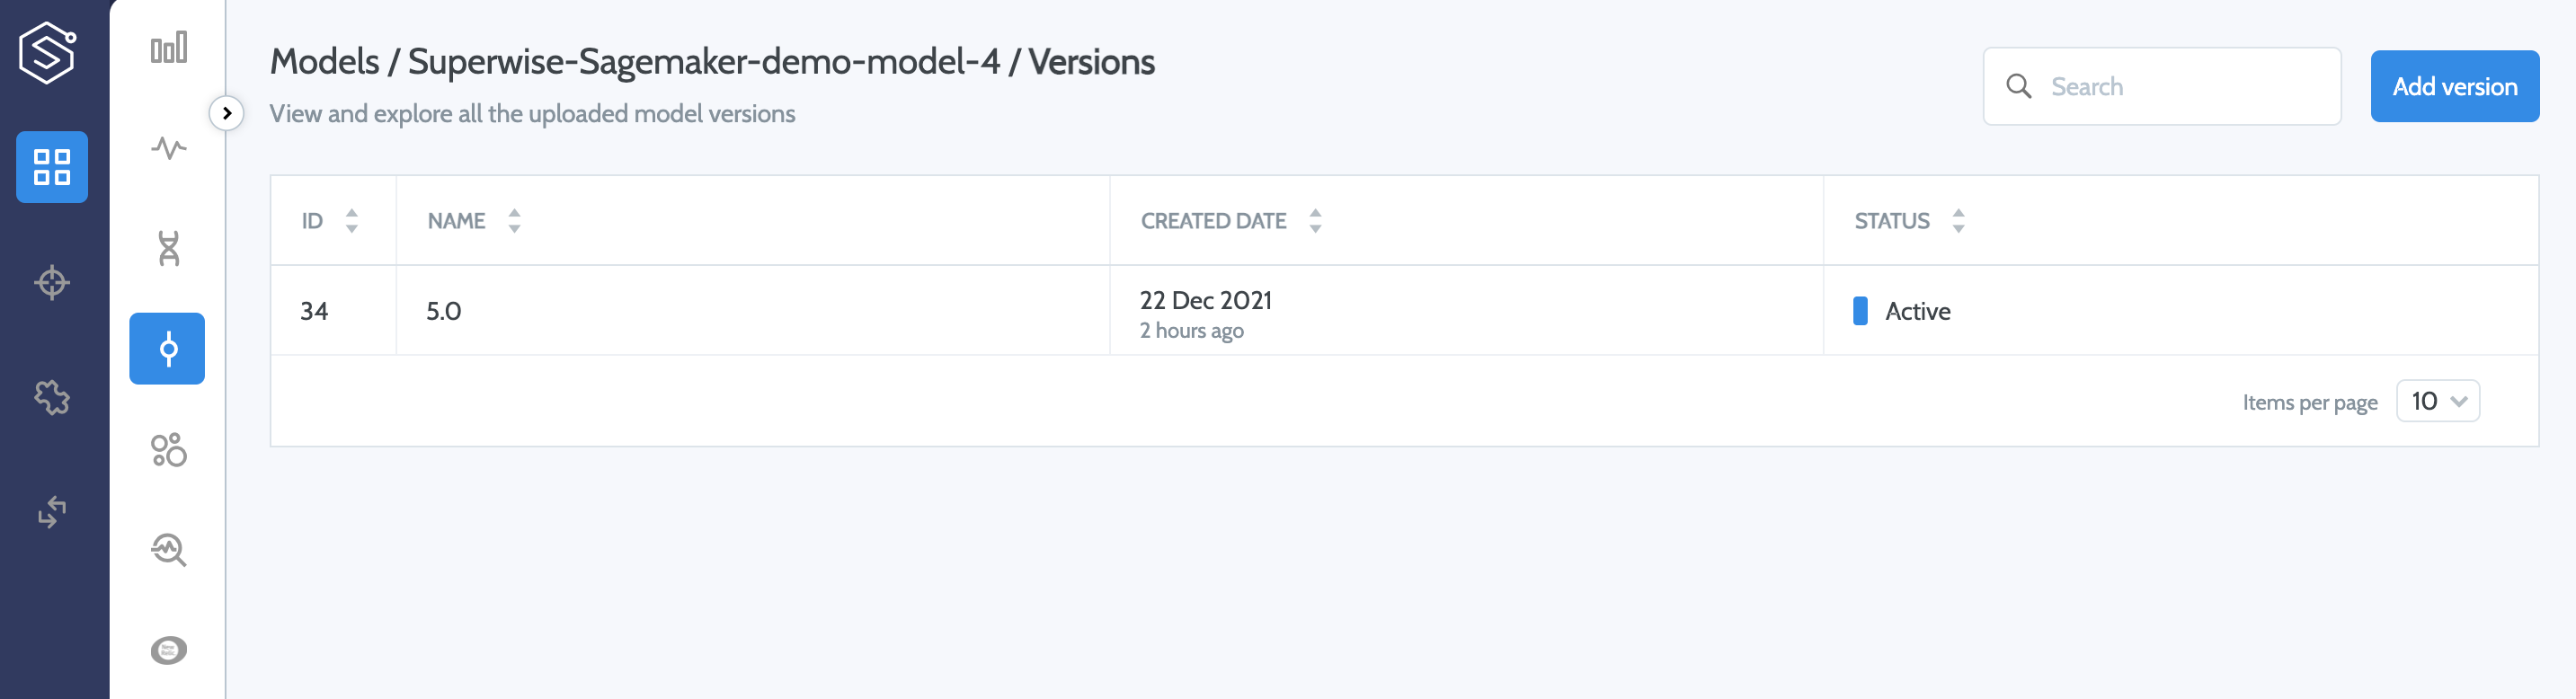

## Part III - monitoring ongoing predictions

Now that we have a *Version* of the model setup with a *Baseline*, we can start sending ongoing model predictions to Superwise to monitor the model's performance in a production settings.

For this demo, we will treat the Test split of the data as our "ongoing predictions".


In [48]:
# insert the record ID as part of the input payload to the model
indexes = X_test.index.map(str)
X_test_inference = X_test.to_numpy()
X_test_inference = np.insert(X_test_inference, 0, indexes, axis=1)
X_test_inference

array([['1388', 0.24, 'Ideal', ..., 3.97, 4.0, 2.47],
       ['50052', 0.58, "'Very Good'", ..., 5.44, 5.42, 3.26],
       ['41645', 0.4, 'Ideal', ..., 4.76, 4.74, 2.95],
       ...,
       ['24786', 1.51, 'Premium', ..., 7.42, 7.38, 4.5],
       ['1332', 0.71, 'Good', ..., 5.8, 5.9, 3.44],
       ['42527', 0.4, 'Ideal', ..., 4.79, 4.77, 2.9]], dtype=object)

In [52]:
predictions = predictor.predict(X_test_inference)
predictions

array([['1388', 718.5],
       ['50052', 3192.5],
       ['41645', 1952.0],
       ...,
       ['24786', 10601.5],
       ['1332', 4107.5],
       ['42527', 2001.0]], dtype=object)

In [68]:
# Note: we provide the column names we declared in the Schema object, 
# so that Superwise.ai will be able to interpret the data

ongoing_predictions = pd.DataFrame(data=predictions, columns=["record_id", "prediction"])
ongoing_predictions["record_id"] = ongoing_predictions["record_id"].astype(int)

ongoing_features = X_test.copy()
ongoing_features['record_id'] = X_test.index
ongoing_data = ongoing_features.merge(ongoing_predictions, how='left', on='record_id')
ongoing_data['ts'] = pd.Timestamp.now()
ongoing_data.head()

,carat,cut,color,clarity,depth,table,x,y,z,record_id,prediction,ts
0,0.24,Ideal,G,VVS1,62.1,56.0,3.97,4.00,2.47,1388,718.5,2021-12-22 19:18:09.175260
1,0.58,'Very Good',F,VVS2,60.0,57.0,5.44,5.42,3.26,50052,3192.5,2021-12-22 19:18:09.175260
2,0.40,Ideal,E,VVS2,62.1,55.0,4.76,4.74,2.95,41645,1952,2021-12-22 19:18:09.175260
3,0.43,Premium,E,VVS2,60.8,57.0,4.92,4.89,2.98,42377,2083.5,2021-12-22 19:18:09.175260
4,1.55,Ideal,E,SI2,62.3,55.0,7.44,7.37,4.61,17244,9876.5,2021-12-22 19:18:09.175260


In [69]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [75]:
# Log the production data in Superwise (Max chunck size = 1000 predictions)

ongoing_data_chuncks = chunks(ongoing_data.to_dict(orient='records'), 1000)

transaction_ids = list()
for ongoing_data_chunck in ongoing_data_chuncks:  
    transaction_id = sw.transaction.log_records(
        task_id=my_task.id,
        version_id=my_version.name,
        records=ongoing_data_chunck
    )
    transaction_ids.append(transaction_id)

Check the status of the logged data

In [76]:
transaction_id = sw.transaction.get(transaction_id=transaction_ids[0]['transaction_id'])
transaction_id.get_properties()['status']

'Passed'

### Optional - report ongoing lables to Superwise.ai

In some cases, our system is able to gather "ground truth" labels for it's predictions.
Often, this happens later on, after the prediciton was already given.

By sending these labels to Superwise.ai, we add another important layer of data to our monitoring solution.

For the purpose of this demo, we can use the test set's labels as the ground truth, simulating a label we collected in production.


In [77]:
# Note: we provide the column names we declared in the Schema object, so that Superwise.ai will be able to interpret the data
indexes = y_test.index.map(str)
ground_truth = pd.DataFrame(data=y_test, columns=['price'])
ground_truth['record_id'] = indexes
ground_truth

,price,record_id
1388,559,1388
50052,2201,50052
41645,1238,41645
42377,1304,42377
17244,6901,17244
...,...,...
29577,705,29577
12564,5278,12564
24786,13157,24786
1332,2960,1332


In [78]:
# Report the labels to Superwise.ai (Max chunck size = 1000 labels)

ground_truth_chuncks = chunks(ground_truth.to_dict(orient='records'), 1000)

transaction_ids = list()
for ground_truth_chunck in ground_truth_chuncks:  
    transaction_id = sw.transaction.log_records(
        task_id=my_task.id,
        records=ground_truth_chunck
    )
    transaction_ids.append(transaction_id)

Check the status of the logged data

In [79]:
transaction_id = sw.transaction.get(transaction_id=transaction_ids[0]['transaction_id'])
transaction_id.get_properties()['status']

'Passed'

### Verifying the setup
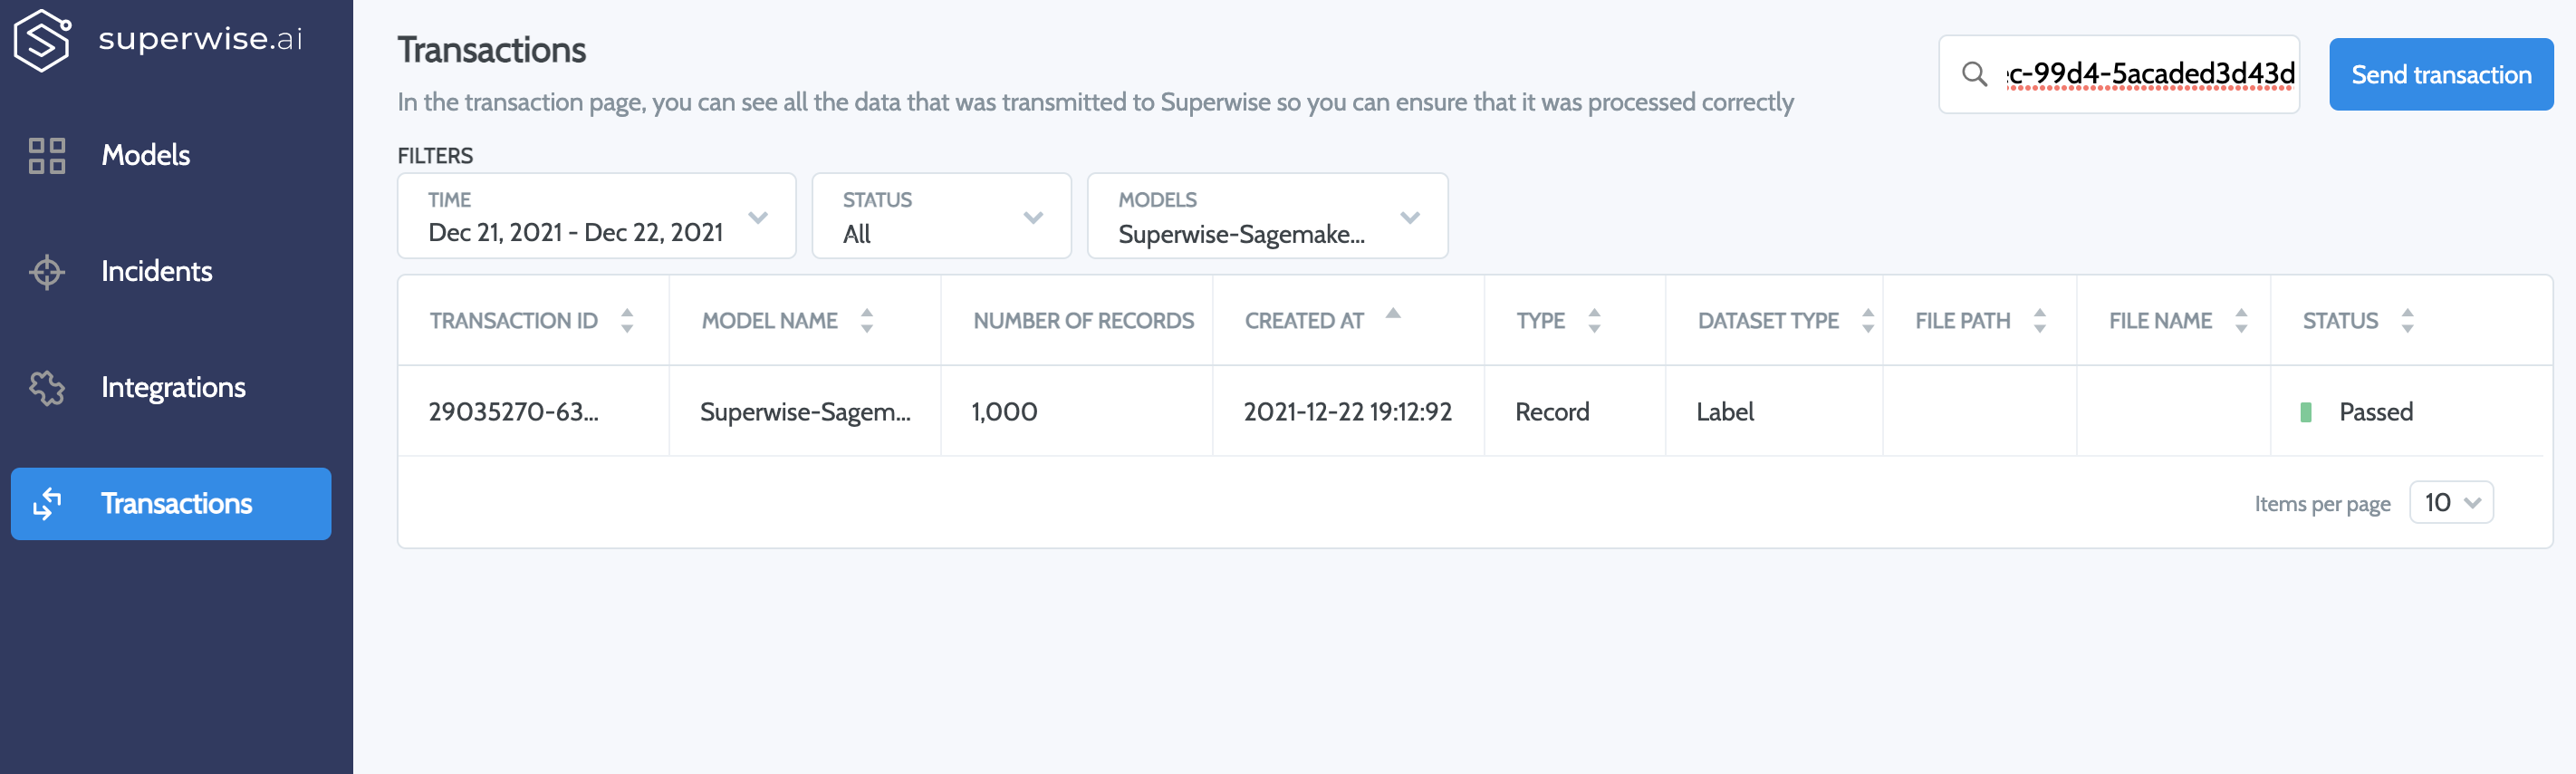

## Don't forget to delete the endpoint !

In [81]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'ResponseMetadata': {'RequestId': 'a35aafb4-766e-4b24-86f6-823fdfffb34f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a35aafb4-766e-4b24-86f6-823fdfffb34f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 22 Dec 2021 17:27:45 GMT'},
  'RetryAttempts': 0}}